In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import io
import re
from tqdm import tqdm
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import import_ipynb
# from custom_matching_layers import *
from sklearn.model_selection import train_test_split
import json

import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

# Load the required submodules
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks

In [2]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
tf.config.experimental.set_visible_devices(devices=gpus[0], device_type='GPU')
tf.config.experimental.set_memory_growth(device=gpus[0], enable=True)

## Preprocessing

In [6]:
print(os.listdir("./datasets"))
print(os.listdir("./datasets/MSRP"))

['MSRP', 'SICK', 'QQP']
['msrp_test.txt', 'msrp_train.txt', 'msrptrain.csv', 'msrp.csv', 'msrptest.csv', 'MSRParaphraseCorpus.msi']


In [4]:
df_msrp = pd.read_csv('./datasets/MSRP/msrp.csv')

In [5]:
df_msrp

,id,qid1,qid2,question1,question2,is_duplicate
0,0,702876,702977,"Amrozi accused his brother , whom he called "" ...","Referring to him as only "" the witness "" , Amr...",1
1,1,2108705,2108831,Yucaipa owned Dominick 's before selling the c...,Yucaipa bought Dominick 's in 1995 for $ 693 m...,0
2,2,1330381,1330521,They had published an advertisement on the Int...,"On June 10 , the ship 's owners had published ...",1
3,3,3344667,3344648,"Around 0335 GMT , Tab shares were up 19 cents ...","Tab shares jumped 20 cents , or 4.6 % , to set...",0
4,4,1236820,1236712,"The stock rose $ 2.11 , or about 11 percent , ...",PG & E Corp. shares jumped $ 1.63 or 8 percent...,1
...,...,...,...,...,...,...
5796,5796,2685984,2686122,"After Hughes refused to rehire Hernandez , he ...",Hernandez filed an Equal Employment Opportunit...,0
5797,5797,339215,339172,There are 103 Democrats in the Assembly and 47...,Democrats dominate the Assembly while Republic...,0
5798,5798,2996850,2996734,Bethany Hamilton remained in stable condition ...,"Bethany , who remained in stable condition aft...",0
5799,5799,2095781,2095812,"Last week the power station ’ s US owners , AE...","The news comes after Drax 's American owner , ...",1


In [6]:
folder_bert = '../bert_en_uncased_L-12_H-768_A-12_3'
tokenizer = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(folder_bert, "assets/vocab.txt"),
     do_lower_case=True)

print("Vocab size:", len(tokenizer.vocab))

Vocab size: 30522


In [7]:
tokens = tokenizer.tokenize("Hello TensorFlow!")
print(tokens)
ids = tokenizer.convert_tokens_to_ids(tokens)
print(ids)

['hello', 'tensor', '##flow', '!']
[7592, 23435, 12314, 999]


In [8]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

In [9]:
def encode_sentence(s):
    try:
        tokens = list(tokenizer.tokenize(str(s)))
        tokens.append('[SEP]')
        return tokenizer.convert_tokens_to_ids(tokens)
    except Exception as e:
        print(s)

tqdm.pandas()
df_msrp['question1_tokenized'] = df_msrp['question1'].progress_apply(lambda x: encode_sentence(x))
df_msrp['question2_tokenized'] = df_msrp['question2'].progress_apply(lambda x: encode_sentence(x))

df_msrp['len_q1'] = df_msrp['question1_tokenized'].map(lambda x: len(x))
df_msrp['len_q2'] = df_msrp['question2_tokenized'].map(lambda x: len(x))

/home/pranav/.local/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 5801/5801 [00:01<00:00, 3712.99it/s]


In [11]:
df_msrp.describe()

,id,qid1,qid2,is_duplicate,len_q1,len_q2
count,5801.000000,5.801000e+03,5.801000e+03,5801.000000,5801.000000,5801.000000
mean,2900.000000,1.684367e+06,1.684367e+06,0.672298,26.099638,26.064644
std,1674.748787,9.916988e+05,9.917017e+05,0.469416,7.025059,7.019784
min,0.000000,2.670000e+02,1.400000e+02,0.000000,8.000000,9.000000
25%,1450.000000,8.068650e+05,8.068650e+05,0.000000,21.000000,21.000000
50%,2900.000000,1.691429e+06,1.691465e+06,1.000000,26.000000,26.000000
75%,4350.000000,2.537987e+06,2.538021e+06,1.000000,31.000000,31.000000
max,5800.000000,3.464314e+06,3.464302e+06,1.000000,51.000000,53.000000


In [13]:
df_msrp.head()

,id,qid1,qid2,question1,question2,is_duplicate,question1_tokenized,question2_tokenized,len_q1,len_q2
0,0,702876,702977,"Amrozi accused his brother , whom he called "" ...","Referring to him as only "" the witness "" , Amr...",1,"[2572, 3217, 5831, 5496, 2010, 2567, 1010, 318...","[7727, 2000, 2032, 2004, 2069, 1000, 1996, 740...",24,25
1,1,2108705,2108831,Yucaipa owned Dominick 's before selling the c...,Yucaipa bought Dominick 's in 1995 for $ 693 m...,0,"[9805, 3540, 11514, 2050, 3079, 11282, 2243, 1...","[9805, 3540, 11514, 2050, 4149, 11282, 2243, 1...",26,32
2,2,1330381,1330521,They had published an advertisement on the Int...,"On June 10 , the ship 's owners had published ...",1,"[2027, 2018, 2405, 2019, 15147, 2006, 1996, 42...","[2006, 2238, 2184, 1010, 1996, 2911, 1005, 105...",22,24
3,3,3344667,3344648,"Around 0335 GMT , Tab shares were up 19 cents ...","Tab shares jumped 20 cents , or 4.6 % , to set...",0,"[2105, 6021, 19481, 13938, 2102, 1010, 21628, ...","[21628, 6661, 5598, 2322, 16653, 1010, 2030, 1...",40,26
4,4,1236820,1236712,"The stock rose $ 2.11 , or about 11 percent , ...",PG & E Corp. shares jumped $ 1.63 or 8 percent...,1,"[1996, 4518, 3123, 1002, 1016, 1012, 2340, 101...","[18720, 1004, 1041, 13058, 1012, 6661, 5598, 1...",29,29


In [15]:
df_msrp.to_pickle("./msrp_tokenized.pkl")

## Building Data

In [4]:
df_msrp = pd.read_pickle("./msrp_tokenized.pkl")

In [5]:
sentence_len = 50
df_msrp = df_msrp[(df_msrp['len_q1']<sentence_len) & (df_msrp['len_q2']<sentence_len)]

In [6]:
df_msrp

,id,qid1,qid2,question1,question2,is_duplicate,question1_tokenized,question2_tokenized,len_q1,len_q2
0,0,702876,702977,"Amrozi accused his brother , whom he called "" ...","Referring to him as only "" the witness "" , Amr...",1,"[2572, 3217, 5831, 5496, 2010, 2567, 1010, 318...","[7727, 2000, 2032, 2004, 2069, 1000, 1996, 740...",24,25
1,1,2108705,2108831,Yucaipa owned Dominick 's before selling the c...,Yucaipa bought Dominick 's in 1995 for $ 693 m...,0,"[9805, 3540, 11514, 2050, 3079, 11282, 2243, 1...","[9805, 3540, 11514, 2050, 4149, 11282, 2243, 1...",26,32
2,2,1330381,1330521,They had published an advertisement on the Int...,"On June 10 , the ship 's owners had published ...",1,"[2027, 2018, 2405, 2019, 15147, 2006, 1996, 42...","[2006, 2238, 2184, 1010, 1996, 2911, 1005, 105...",22,24
3,3,3344667,3344648,"Around 0335 GMT , Tab shares were up 19 cents ...","Tab shares jumped 20 cents , or 4.6 % , to set...",0,"[2105, 6021, 19481, 13938, 2102, 1010, 21628, ...","[21628, 6661, 5598, 2322, 16653, 1010, 2030, 1...",40,26
4,4,1236820,1236712,"The stock rose $ 2.11 , or about 11 percent , ...",PG & E Corp. shares jumped $ 1.63 or 8 percent...,1,"[1996, 4518, 3123, 1002, 1016, 1012, 2340, 101...","[18720, 1004, 1041, 13058, 1012, 6661, 5598, 1...",29,29
...,...,...,...,...,...,...,...,...,...,...
5796,5796,2685984,2686122,"After Hughes refused to rehire Hernandez , he ...",Hernandez filed an Equal Employment Opportunit...,0,"[2044, 8099, 4188, 2000, 2128, 20908, 13688, 1...","[13688, 6406, 2019, 5020, 6107, 4495, 3222, 12...",18,12
5797,5797,339215,339172,There are 103 Democrats in the Assembly and 47...,Democrats dominate the Assembly while Republic...,0,"[2045, 2024, 9800, 8037, 1999, 1996, 3320, 199...","[8037, 16083, 1996, 3320, 2096, 10643, 2491, 1...",12,11
5798,5798,2996850,2996734,Bethany Hamilton remained in stable condition ...,"Bethany , who remained in stable condition aft...",0,"[16559, 5226, 2815, 1999, 6540, 4650, 5095, 20...","[16559, 1010, 2040, 2815, 1999, 6540, 4650, 20...",14,20
5799,5799,2095781,2095812,"Last week the power station ’ s US owners , AE...","The news comes after Drax 's American owner , ...",1,"[2197, 2733, 1996, 2373, 2276, 1521, 1055, 214...","[1996, 2739, 3310, 2044, 2852, 8528, 1005, 105...",33,40


In [7]:
def bert_encode(data):
    sentence1 = tf.ragged.constant(data['question1_tokenized'])
    sentence2 = tf.ragged.constant(data['question2_tokenized'])
    
    cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
    input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)

    input_mask = tf.ones_like(input_word_ids).to_tensor()

    type_cls = tf.zeros_like(cls)
    type_s1 = tf.zeros_like(sentence1)
    type_s2 = tf.ones_like(sentence2)
    input_type_ids = tf.concat([type_cls, type_s1, type_s2], axis=-1).to_tensor()
    inputs = {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}
    return inputs

In [8]:
train_msrp, test_msrp = train_test_split(df_msrp, test_size=0.2)

In [9]:
folder_bert = '../bert_en_uncased_L-12_H-768_A-12_3'
tokenizer = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(folder_bert, "assets/vocab.txt"),
     do_lower_case=True)

print("Vocab size:", len(tokenizer.vocab))

Vocab size: 30522


In [10]:
msrp_train = bert_encode(train_msrp)
msrp_train_labels = train_msrp['is_duplicate']

msrp_test = bert_encode(test_msrp)
msrp_test_labels = test_msrp['is_duplicate']

In [11]:
for key, value in msrp_train.items():
    print(f'{key:15s} shape: {value.shape}')

print(f'Train_labels shape: {msrp_train_labels.shape}')

input_word_ids  shape: (4634, 98)
input_mask      shape: (4634, 98)
input_type_ids  shape: (4634, 98)
Train_labels shape: (4634,)


## Build Model

In [12]:
hub_encoder = hub.KerasLayer(folder_bert,trainable=True)

In [13]:
print(f"The Hub encoder has {len(hub_encoder.trainable_variables)} trainable variables")

The Hub encoder has 199 trainable variables


In [14]:
result = hub_encoder(
    inputs = dict(
    input_word_ids=msrp_train['input_word_ids'][:10],
    input_mask=msrp_train['input_mask'][:10],
    input_type_ids=msrp_train['input_type_ids'][:10],),
    training=False,
)

In [15]:
result.keys()

dict_keys(['sequence_output', 'pooled_output', 'default', 'encoder_outputs'])

In [16]:
result['pooled_output']

<tf.Tensor: shape=(10, 768), dtype=float32, numpy=
array([[-0.98736864, -0.8870846 , -0.99976957, ..., -0.99475145,
        -0.9383457 ,  0.9821567 ],
       [-0.9968034 , -0.9467628 , -0.99998146, ..., -0.998937  ,
        -0.9655365 ,  0.9889258 ],
       [-0.9958344 , -0.94790304, -0.9999467 , ..., -0.9974515 ,
        -0.9632373 ,  0.9928619 ],
       ...,
       [-0.99223065, -0.94487053, -0.9999586 , ..., -0.9992766 ,
        -0.9674017 ,  0.9839096 ],
       [-0.9916153 , -0.91362923, -0.9999602 , ..., -0.9990443 ,
        -0.93803537,  0.9774511 ],
       [-0.99401826, -0.93788624, -0.99995685, ..., -0.9990079 ,
        -0.96140784,  0.9856024 ]], dtype=float32)>

In [17]:
bert_inputs = dict(
    input_word_ids=tf.keras.layers.Input(shape=(None,), dtype=tf.int32),
    input_mask=tf.keras.layers.Input(shape=(None,), dtype=tf.int32),
    input_type_ids=tf.keras.layers.Input(shape=(None,), dtype=tf.int32),
)

In [18]:
bert_output = hub_encoder(bert_inputs)

In [19]:
bert_classifier = layers.Dropout(.1)(bert_output['pooled_output'])
bert_classifier = x = layers.Dense(2, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=.02))(bert_classifier)

In [20]:
model = keras.Model(inputs=bert_inputs, outputs=bert_classifier, name="Bert_model")
model.summary()

Model: "Bert_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        {'default': (None, 7 109482241   input_2[0][0]                    
                                                                 input_3[0][0]           

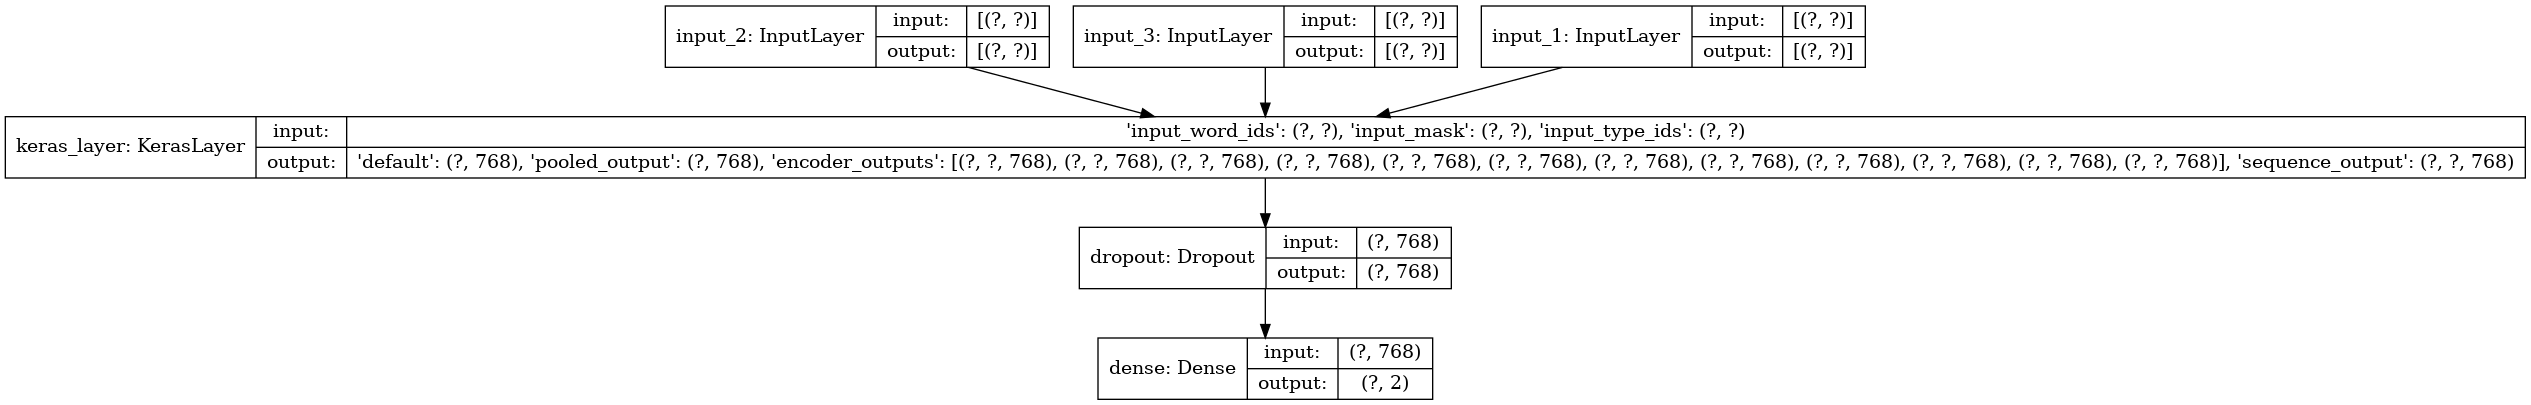

In [21]:
keras.utils.plot_model(model, "Bert_model.png", show_shapes=True)

In [22]:
# Set up epochs and steps
epochs = 3
batch_size = 8
eval_batch_size = 8

train_data_size = len(msrp_train_labels)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

# creates an optimizer with learning rate schedule
optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)

# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [23]:
hist = model.fit(
      msrp_train, msrp_train_labels,
      validation_data=(msrp_test, msrp_test_labels),
      batch_size=8,
      epochs=3)


Epoch 1/3
580/580 [==============================] - 197s 340ms/step - loss: 0.5574 - accuracy: 0.6994 - val_loss: 0.3975 - val_accuracy: 0.8240
Epoch 2/3
580/580 [==============================] - 197s 340ms/step - loss: 0.2941 - accuracy: 0.8807 - val_loss: 0.3804 - val_accuracy: 0.8369
Epoch 3/3
580/580 [==============================] - 198s 341ms/step - loss: 0.1243 - accuracy: 0.9599 - val_loss: 0.4698 - val_accuracy: 0.8412


{'loss': [0.5573986768722534, 0.2940622568130493, 0.12434660643339157], 'accuracy': [0.6993957757949829, 0.8806646466255188, 0.9598618745803833], 'val_loss': [0.39747413992881775, 0.38043299317359924, 0.4697630703449249], 'val_accuracy': [0.8239861726760864, 0.8369283676147461, 0.8412424325942993]}


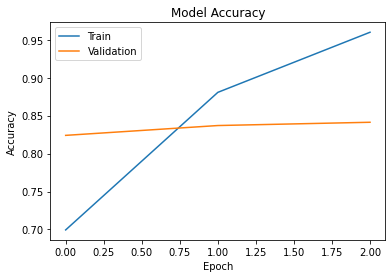

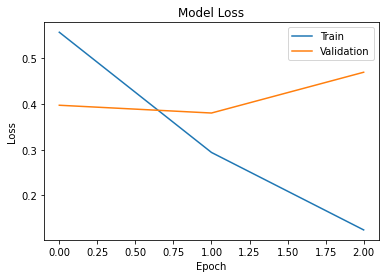

In [24]:
# Plot accuracy
print(hist.history)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [25]:
model.save_weights("results/bert_model_msrp",save_format="h5")

In [26]:
with open('results/bert_model_msrp.json', 'w') as f:
    json.dump(hist.history, f)